<a href="https://colab.research.google.com/github/JepStar990/3d-printing-mlops/blob/main/Copy_of_02_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
'''
from google.colab import drive
import os
import shutil # Import shutil for removing directories

# Define the mount point
mountpoint = '/content/drive'

# Check if the mount point exists and is a directory on the runtime disk
if os.path.exists(mountpoint) and os.path.isdir(mountpoint):
    # Check if the directory is not empty
    if os.listdir(mountpoint):
        print(f"Mountpoint {mountpoint} on the runtime disk is not empty. Cleaning up before mounting...")
        try:
            # Remove all contents within the mountpoint on the runtime disk
            # This does NOT delete your Google Drive files.
            for item in os.listdir(mountpoint):
                item_path = os.path.join(mountpoint, item)
                if os.path.isfile(item_path):
                    os.remove(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
            print(f"Mountpoint {mountpoint} on the runtime disk cleaned successfully.")
        except Exception as e:
            print(f"Error cleaning mountpoint {mountpoint} on the runtime disk: {e}")
    else:
        print(f"Mountpoint {mountpoint} on the runtime disk is already empty.")
else:
    # If the mountpoint doesn't exist, create it. This is unlikely in Colab,
    # but good practice.
    try:
        os.makedirs(mountpoint, exist_ok=True)
        print(f"Mountpoint {mountpoint} on the runtime disk created.")
    except Exception as e:
        print(f"Error creating mountpoint {mountpoint} on the runtime disk: {e}")


drive.mount(mountpoint, force_remount=True)

# --- Add code to list directory tree ---
# Define the Google Drive mount point
drive_mount_point = '/content/drive/My Drive/'

print(f"\nListing directory tree of: {drive_mount_point}")

# Use the !tree command to list the directory structure.
# -L 2 specifies a depth of 2 levels (adjust as needed)

# Check if tree is installed, if not, install it
# Use a more robust check by trying to execute tree and capturing the output
try:
    result = os.system('tree --version > /dev/null 2>&1')
    tree_installed = (result == 0) # os.system returns 0 if command was successful
except Exception as e:
    print(f"Error checking tree installation: {e}")
    tree_installed = False

if not tree_installed:
    print("Installing tree...")
    # Ensure the installation command runs
    install_result = os.system('apt-get update -qq && apt-get install tree -qq')
    if install_result == 0:
        print("tree installed successfully.")
        tree_installed = True
    else:
        print("Failed to install tree.")


# List the directory tree with a depth of 3 levels as an example
# Adjust the depth (-L 3) if you need to see more or fewer levels
if tree_installed:
    !tree "{drive_mount_point}" -L 4
else:
    print("Tree command is not available. Skipping directory listing.")

print("\nDirectory tree listing complete.")
# --- End of added code ---
'''

'\nfrom google.colab import drive\nimport os\nimport shutil # Import shutil for removing directories\n\n# Define the mount point\nmountpoint = \'/content/drive\'\n\n# Check if the mount point exists and is a directory on the runtime disk\nif os.path.exists(mountpoint) and os.path.isdir(mountpoint):\n    # Check if the directory is not empty\n    if os.listdir(mountpoint):\n        print(f"Mountpoint {mountpoint} on the runtime disk is not empty. Cleaning up before mounting...")\n        try:\n            # Remove all contents within the mountpoint on the runtime disk\n            # This does NOT delete your Google Drive files.\n            for item in os.listdir(mountpoint):\n                item_path = os.path.join(mountpoint, item)\n                if os.path.isfile(item_path):\n                    os.remove(item_path)\n                elif os.path.isdir(item_path):\n                    shutil.rmtree(item_path)\n            print(f"Mountpoint {mountpoint} on the runtime disk cleaned 

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install wfdb scipy --quiet

In [27]:
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat
import logging
from datetime import datetime

# Define a variable to control the size of processing batches
BATCH_SIZE = 500 # You can adjust this value

# --- Logging Setup ---
# Define the path for the log file within your project structure
log_directory = '/content/drive/My Drive/ECG_Arrhythmia_Project/logs'
os.makedirs(log_directory, exist_ok=True) # Create the log directory if it doesn't exist

# Generate a timestamp for the log file name
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_file_path = os.path.join(log_directory, f'preprocessing_log_{timestamp}.log')

# Configure logging
# Remove any existing handlers to avoid duplicate logs if the cell is run multiple times
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename=log_file_path,
                    filemode='w') # Use 'w' to overwrite the log file each run

# Add a handler to output logs to the console as well - REMOVED TO STOP CONSOLE OUTPUT
# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# console.setFormatter(formatter)
# logging.getLogger('').addHandler(console)

logging.info("Logging configured. Starting data preprocessing.")
# --- End Logging Setup ---


# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/raw/WFDB_ChapmanShaoxing'

# Define the directory to save raw data batches
raw_save_directory = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/raw_batches'
os.makedirs(raw_save_directory, exist_ok=True) # Create the directory if it doesn't exist

# Get a list of all record names (assuming the .hea files have the record names)
# Add a check for directory existence before listing
if not os.path.exists(dataset_path):
     logging.error(f"Raw dataset directory not found: {dataset_path}. Please check the path.")
     print(f"Error: Raw dataset directory not found at {dataset_path}. Please check the path and re-run the cell.")
     all_records = [] # Set to empty to prevent further errors
else:
    all_records = [f[:-4] for f in os.listdir(dataset_path) if f.endswith('.hea')]
    all_records.sort() # Sort to ensure consistent order

# Select the first 100 records for EDA as requested
# records_subset = all_records[:11000] # Keep the subset size as 10 for now for faster testing of batching
records_subset = all_records # Process all records

logging.info(f"Attempting to load a subset of {len(records_subset)} records using scipy and manual .hea parsing, with batch size {BATCH_SIZE}...")

successfully_loaded_records = []
skipped_records = []

num_batches = (len(records_subset) + BATCH_SIZE - 1) // BATCH_SIZE

# Process records in batches
for batch_index in range(num_batches):
    start_index = batch_index * BATCH_SIZE
    end_index = min((batch_index + 1) * BATCH_SIZE, len(records_subset))
    batch_records_names = records_subset[start_index:end_index]

    batch_save_path_signal = os.path.join(raw_save_directory, f'raw_signal_batch_{batch_index}.npy')
    batch_save_path_label = os.path.join(raw_save_directory, f'raw_label_batch_{batch_index}.npy')

    # --- Check if batch files already exist ---
    if os.path.exists(batch_save_path_signal) and os.path.exists(batch_save_path_label):
        logging.info(f"Raw data batch {batch_index} already exists. Skipping loading and saving for this batch.")
        # To accurately count successfully loaded records even if skipping,
        # we need to know how many records were *intended* for this batch.
        successfully_loaded_records.extend(batch_records_names) # Assume all records in a skipped batch were successful
        continue
    # --- End of added check ---


    batch_signals = []
    batch_labels = []
    batch_loaded_record_names = []

    logging.info(f"Processing batch {batch_index + 1}/{num_batches} containing {len(batch_records_names)} records.")

    for record_name in batch_records_names:
        hea_file = os.path.join(dataset_path, record_name + '.hea')
        mat_file = os.path.join(dataset_path, record_name + '.mat')

        # Sanity Check: Check if both .hea and .mat files exist
        if not os.path.exists(hea_file):
            logging.warning(f"Skipping record {record_name}: .hea file not found locally.")
            skipped_records.append(record_name)
            continue
        if not os.path.exists(mat_file):
            logging.warning(f"Skipping record {record_name}: .mat file not found locally.")
            skipped_records.append(record_name)
            continue

        try:
            # Load signal data from .mat file using scipy.io.loadmat
            mat_data = loadmat(mat_file)
            signal = mat_data.get('val')

            if signal is None:
                 logging.warning(f"Skipping record {record_name}: Could not find expected signal key ('val') in .mat file.")
                 skipped_records.append(record_name)
                 continue

            # Check and correct signal shape if transposed (from 12x5000 to 5000x12)
            if signal.shape == (12, 5000):
                signal = signal.T # Transpose the signal to be 5000x12
                logging.info(f"Transposed signal shape for record {record_name} to {signal.shape}.")
            elif signal.shape != (5000, 12):
                 logging.warning(f"Skipping record {record_name}: Signal has unexpected shape {signal.shape}. Expected (5000, 12) or (12, 5000).")
                 skipped_records.append(record_name)
                 continue


            # Manually parse .hea file to extract labels from comments
            diagnosis_code = "Unknown"
            with open(hea_file, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line.startswith('#'): # Comments start with '#'
                        if 'Dx:' in line:
                            # Extract the part after 'Dx:'
                            dx_part = line.split('Dx:')[1].strip()
                            # Take the first code if there are multiple, and remove any trailing commas or spaces
                            diagnosis_code = dx_part.split(',')[0].strip()
                            # logging.info(f"Extracted diagnosis code '{diagnosis_code}' for record {record_name}.")
                            break # Assuming one primary diagnosis per record

            # Define the mapping from diagnosis codes to major arrhythmia classes
            # This mapping should be comprehensive based on the dataset documentation
            # (Placeholder - needs to be fully defined based on dataset specifics)
            dx_code_mapping = {
                '426177001': 'Normal Sinus Rhythm',
                '164889003': 'Atrial Fibrillation',
                '164909002': 'Supraventricular Tachycardia',
                '270492004': 'Ventricular Tachycardia',
                '164947007': 'Ventricular Fibrillation',
                '59118001': 'Atrial Flutter',
                '426783006': 'Bradycardia',
                '713427006': 'Left Bundle Branch Block',
                '284470004': 'Nonspecific ST-T Wave Abnormality',
                '429622005': 'Q Wave Abnormal',
                '427172004': 'Sinus Arrhythmia',
                '426995002': 'Sinus Tachycardia',
                '251142005': 'Sinoatrial block', # Added based on potential dataset codes
                '47665007': 'Junctional Rhythm', # Added
                '10370003': 'Complete heart block', # Added
                '53741008': 'First degree Atrioventricular block', # Added
                '27885002': 'Second degree Atrioventricular block', # Added
                '164917005': 'Supraventricular Premature Beats', # Added
                '17338001': 'Ventricular Premature Beats', # Added
                '427084000': 'Bundle branch block', # Added
                '427393009': 'QRS interval abnormal', # Added
                '164876005': 'T wave abnormal', # Added
                '698252002': 'ST segment abnormal', # Added
                # Add all relevant codes from the dataset documentation based on your knowledge
            }

            # Map the diagnosis code to a major arrhythmia class
            mapped_label = dx_code_mapping.get(diagnosis_code, 'Other') # Map unknown or unlisted codes to 'Other'
            # logging.info(f"Mapped diagnosis code '{diagnosis_code}' to label '{mapped_label}' for record {record_name}.")


            # Append data if signal is not None and has the corrected expected shape (5000, 12)
            if signal is not None and signal.shape == (5000, 12):
                 batch_signals.append(signal)
                 batch_labels.append(mapped_label)
                 batch_loaded_record_names.append(record_name)
                 successfully_loaded_records.append(record_name)
                 # logging.info(f"Successfully loaded record {record_name} with shape {signal.shape}.")


            else:
                # This else block should ideally not be reached if the shape check above is thorough
                logging.warning(f"Skipping record {record_name}: Signal has unexpected shape {signal.shape if signal is not None else 'None'} after processing.")
                skipped_records.append(record_name)


        except Exception as e:
            logging.error(f"Error loading or processing record {record_name}: {e}. Skipping this record.")
            skipped_records.append(record_name)
            continue

    # Save the current batch if not empty
    if batch_signals:
        try:
            np.save(batch_save_path_signal, np.array(batch_signals))
            np.save(batch_save_path_label, np.array(batch_labels))
            logging.info(f"Raw data batch {batch_index} containing {len(batch_signals)} records saved.")
        except Exception as e:
            logging.error(f"Error saving raw data batch {batch_index}: {e}")


logging.info(f"Data loading complete. Attempted to process {len(records_subset)} records in {num_batches} batches.")
logging.info(f"Successfully loaded {len(successfully_loaded_records)} records.")
logging.info(f"Skipped {len(skipped_records)} records during loading attempt.")

# Update the main data variables to be empty as data is now in batches
# Subsequent steps should load from the saved batches.
all_signals = []
all_labels = []
records_loaded = [] # This list was intended to track loaded records but is cleared after batching

logging.info("Raw data loading and batch saving complete.")

In [28]:
import logging
import numpy as np
import os

# Identify indices of records to remove based on missing values or all-zero leads
# We need to process the data in batches as saved in the previous step.

logging.info("Identifying and removing invalid samples (missing values or all-zero leads) in batches...")
print("\nIdentifying and removing invalid samples (missing values or all-zero leads) in batches...")

raw_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/raw_batches'
cleaned_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/cleaned' # New directory for cleaned batches
os.makedirs(cleaned_batches_dir, exist_ok=True)
logging.info(f"Saving cleaned batches to: {cleaned_batches_dir}")

# List all raw signal and label batch files
raw_signal_batch_files = sorted([f for f in os.listdir(raw_batches_dir) if f.startswith('raw_signal_batch_') and f.endswith('.npy')])
raw_label_batch_files = sorted([f for f in os.listdir(raw_batches_dir) if f.startswith('raw_label_batch_') and f.endswith('.npy')])

# Ensure signal and label batches match
if len(raw_signal_batch_files) != len(raw_label_batch_files):
    logging.error("Mismatch in the number of raw signal and label batch files. Cannot proceed with cleaning.")
    print("Error: Mismatch in the number of raw signal and label batch files. Cannot proceed with cleaning.")
else:
    num_batches = len(raw_signal_batch_files)
    logging.info(f"Found {num_batches} raw data batches to process for cleaning.")

    total_records_before_cleaning = 0
    total_records_removed = 0
    total_records_after_cleaning = 0

    for batch_index in range(num_batches):
        signal_batch_file = raw_signal_batch_files[batch_index]
        label_batch_file = raw_label_batch_files[batch_index]

        raw_signal_batch_path = os.path.join(raw_batches_dir, signal_batch_file)
        raw_label_batch_path = os.path.join(raw_batches_dir, label_batch_file)

        cleaned_signal_batch_path = os.path.join(cleaned_batches_dir, f'cleaned_signal_batch_{batch_index}.npy')
        cleaned_label_batch_path = os.path.join(cleaned_batches_dir, f'cleaned_label_batch_{batch_index}.npy')

        # Check if cleaned batch files already exist
        if os.path.exists(cleaned_signal_batch_path) and os.path.exists(cleaned_label_batch_path):
            logging.info(f"Cleaned batch {batch_index} already exists. Skipping cleaning for this batch.")
            # Assuming the number of records after cleaning is the number of records in the saved cleaned batch
            try:
                 cleaned_batch_signals = np.load(cleaned_signal_batch_path)
                 total_records_before_cleaning += cleaned_batch_signals.shape[0] + (np.load(raw_signal_batch_path).shape[0] - cleaned_batch_signals.shape[0]) # This might not be accurate if raw batch changed
                 total_records_after_cleaning += cleaned_batch_signals.shape[0]
                 total_records_removed += (np.load(raw_signal_batch_path).shape[0] - cleaned_batch_signals.shape[0])
            except Exception as e:
                 logging.warning(f"Could not load cleaned batch {batch_index} for counting: {e}")

            continue # Skip to the next batch

        try:
            # Load the current raw data batch
            current_batch_signals = np.load(raw_signal_batch_path)
            current_batch_labels = np.load(raw_label_batch_path, allow_pickle=True)
            # No need to load record names here unless they were saved in raw_batches

            logging.info(f"Processing raw data batch {batch_index} with {current_batch_signals.shape[0]} records for cleaning.")
            total_records_before_cleaning += current_batch_signals.shape[0]

            # Identify indices of records to keep within this batch
            indices_to_keep_batch = []
            removed_count_batch = 0

            for i in range(current_batch_signals.shape[0]):
                signal = current_batch_signals[i]
                is_invalid = False

                # Check for missing values (NaNs)
                if np.isnan(signal).sum() > 0:
                    # logging.warning(f"Removing record at index {i} in batch {batch_index}: Contains missing values.")
                    is_invalid = True

                # Check for all-zero leads
                if (signal == 0).all(axis=0).any():
                    if not is_invalid:
                         # logging.warning(f"Removing record at index {i} in batch {batch_index}: Contains at least one all-zero lead.")
                         pass # Suppress print/log here to reduce verbosity in batch loop
                    is_invalid = True

                if not is_invalid:
                    indices_to_keep_batch.append(i)
                else:
                    removed_count_batch += 1

            # Create new arrays with cleaned data for the current batch
            cleaned_batch_signals = current_batch_signals[indices_to_keep_batch]
            cleaned_batch_labels = current_batch_labels[indices_to_keep_batch]

            total_records_removed += removed_count_batch
            total_records_after_cleaning += cleaned_batch_signals.shape[0]

            # Save the cleaned batch if not empty
            if cleaned_batch_signals.shape[0] > 0:
                np.save(cleaned_signal_batch_path, cleaned_batch_signals)
                np.save(cleaned_label_batch_path, cleaned_batch_labels)
                logging.info(f"Cleaned batch {batch_index} saved with {cleaned_batch_signals.shape[0]} records (removed {removed_count_batch}).")
            else:
                 logging.warning(f"Cleaned batch {batch_index} is empty. Not saving empty batch file.")


        except Exception as e:
            logging.error(f"Error processing or saving cleaned batch {batch_index}: {e}. Skipping this batch.")
            # If an error occurs, we should ideally mark this batch as failed or retry.
            # For now, just log and continue. The counts will reflect the skipped batch.
            pass # Continue to the next batch

    # Report cleaning results
    logging.info(f"Data cleaning complete.")
    logging.info(f"Total records before cleaning: {total_records_before_cleaning}")
    logging.info(f"Total records removed: {total_records_removed}")
    logging.info(f"Total records remaining after cleaning: {total_records_after_cleaning}")

    print(f"\nTotal records before cleaning: {total_records_before_cleaning}")
    print(f"Total records removed: {total_records_removed}")
    print(f"Total records remaining after cleaning: {total_records_after_cleaning}")


# After processing all batches, 'all_signals' and 'all_labels' are empty.
# Subsequent steps will need to load from the saved cleaned batches in the 'cleaned' directory.
all_signals = []
all_labels = []
records_loaded = [] # This list is not used in the batch processing
logging.info("'all_signals' and 'all_labels' cleared after batch processing.")


Identifying and removing invalid samples (missing values or all-zero leads) in batches...

Total records before cleaning: 10247
Total records removed: 15
Total records remaining after cleaning: 10232


In [29]:
from scipy.signal import butter, filtfilt
import os # Import os for path joining
import numpy as np # Ensure numpy is imported
import logging # Import logging

print("\nApplying Butterworth low-pass filter (50 Hz cutoff) to loaded signals...")
logging.info("Starting Butterworth low-pass filtering (50 Hz cutoff)...")


# Filter parameters
filter_order = 4 # Order of the filter
cutoff_frequency = 50 # Hz
sampling_frequency = 500 # Hz (Confirmed from EDA)

# Normalize the cutoff frequency to the Nyquist frequency to (sampling_frequency / 2)
normalized_cutoff_frequency = cutoff_frequency / (sampling_frequency / 2)

# Get the filter coefficients (b, a) for the Butterworth filter
# 'lowpass' specifies a low-pass filter
b, a = butter(filter_order, normalized_cutoff_frequency, btype='lowpass')

# Define the directory for saving Butterworth filtered data batches
save_directory_butterworth = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/butterworth' # Define a subdirectory for intermediate saves
os.makedirs(save_directory_butterworth, exist_ok=True) # Create the directory if it doesn't exist
logging.info(f"Saving Butterworth filtered batches to: {save_directory_butterworth}")

# Load cleaned batches and process in batches for filtering
cleaned_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/cleaned' # Load from cleaned batches

# Add a check for directory existence before listing
if not os.path.exists(cleaned_batches_dir):
    logging.error(f"Cleaned batches directory not found: {cleaned_batches_dir}. Please ensure the cleaning cell ran successfully.")
    print(f"Error: Cleaned batches directory not found at {cleaned_batches_dir}. Please ensure the cleaning cell ran successfully and re-run.")
    cleaned_signal_batch_files = [] # Set to empty list to prevent further errors
else:
    cleaned_signal_batch_files = sorted([f for f in os.listdir(cleaned_batches_dir) if f.startswith('cleaned_signal_batch_') and f.endswith('.npy')])
    logging.info(f"Found {len(cleaned_signal_batch_files)} cleaned batches to process for Butterworth filtering.")


for batch_index, batch_file in enumerate(cleaned_signal_batch_files):
    cleaned_signal_batch_path = os.path.join(cleaned_batches_dir, batch_file)
    batch_save_path = os.path.join(save_directory_butterworth, f'butterworth_filtered_signal_batch_{batch_index}.npy')

    # Check if the processed batch already exists to skip reprocessing
    if os.path.exists(batch_save_path):
        logging.info(f"Butterworth filtered batch {batch_index} already exists. Skipping processing for this batch.")
        continue # Skip to the next batch if already processed
    # --- Save only if the batch was not skipped ---
    else:
        try:
            # Load the current cleaned data batch
            current_batch_signals = np.load(cleaned_signal_batch_path)
            logging.info(f"Loaded cleaned data batch {batch_index} with shape {current_batch_signals.shape}.")

            # Initialize a list to store filtered signals for the current batch
            filtered_batch_signals = []

            # Apply the filter to each signal within the current batch
            for signal in current_batch_signals:
                filtered_signal = np.zeros_like(signal)
                for lead_idx in range(signal.shape[1]):
                    filtered_lead = filtfilt(b, a, signal[:, lead_idx])
                    filtered_signal[:, lead_idx] = filtered_lead
                filtered_batch_signals.append(filtered_signal)

            # Convert the list of filtered signals for the batch to a NumPy array
            filtered_batch_signals_np = np.array(filtered_batch_signals)

            # Save the current batch of filtered signals
            np.save(batch_save_path, filtered_batch_signals_np)
            logging.info(f"Butterworth filtered signal batch {batch_index} saved.")

        except Exception as e:
            logging.error(f"Error processing or saving Butterworth filtered signal batch {batch_index}: {e}. Skipping this batch.")
            pass # Continue to the next batch


print("Butterworth low-pass filtering applied in batches.")
logging.info("Butterworth low-pass filtering applied in batches.")

# After processing all batches, 'all_signals' will be empty as we are processing and saving batches directly.
# Subsequent steps will need to load from the saved batches in the 'butterworth' directory.
all_signals = []
logging.info("'all_signals' cleared after batch processing.")


Applying Butterworth low-pass filter (50 Hz cutoff) to loaded signals...
Butterworth low-pass filtering applied in batches.


In [30]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import os # Import os for path joining
import numpy as np # Ensure numpy is imported
import logging # Import logging

print("\nApplying LOESS filter for baseline wander removal...")
logging.info("Starting LOESS filtering for baseline wander removal...")


# Define LOESS parameters
# The 'frac' parameter controls the smoothness. A larger value means a smoother fit.
# A typical value for ECG baseline wander removal might be between 0.01 and 0.1.
# We will use a value that captures the slow-moving baseline.
loess_frac = 0.05 # This value might need tuning based on visual inspection

# Define the directory for saving LOESS filtered data batches
save_directory_loess = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/loess'
os.makedirs(save_directory_loess, exist_ok=True) # Create the directory if it doesn't exist
logging.info(f"Saving LOESS filtered batches to: {save_directory_loess}")

# Load Butterworth filtered batches and process in batches for LOESS filtering
butterworth_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/butterworth'

# --- Add check for directory existence before listing ---
print(f"Checking for existence of Butterworth batches directory: {butterworth_batches_dir}")
if os.path.exists(butterworth_batches_dir):
    print("Butterworth batches directory exists.")
    butterworth_signal_batch_files = sorted([f for f in os.listdir(butterworth_batches_dir) if f.startswith('butterworth_filtered_signal_batch_') and f.endswith('.npy')])
    logging.info(f"Found {len(butterworth_signal_batch_files)} Butterworth filtered batches to process for LOESS filtering.")
    print(f"Found {len(butterworth_signal_batch_files)} Butterworth filtered batches to process for LOESS filtering.")

else:
    print("Butterworth batches directory does NOT exist.")
    logging.error(f"Butterworth batches directory not found: {butterworth_batches_dir}")
    butterworth_signal_batch_files = [] # Set to empty list to prevent further errors


for batch_index, batch_file in enumerate(butterworth_signal_batch_files):
    butterworth_signal_batch_path = os.path.join(butterworth_batches_dir, batch_file)
    batch_save_path = os.path.join(save_directory_loess, f'loess_filtered_signal_batch_{batch_index}.npy')

    # Check if the processed batch already exists to skip reprocessing
    if os.path.exists(batch_save_path):
        logging.info(f"LOESS filtered batch {batch_index} already exists. Skipping processing for this batch.")
        continue # Skip to the next batch if already processed
    # --- Save only if the batch was not skipped ---
    else:
        try:
            # Load the current Butterworth filtered data batch
            current_batch_signals = np.load(butterworth_signal_batch_path)
            logging.info(f"Loaded Butterworth filtered batch {batch_index} with shape {current_batch_signals.shape}.")

            # Initialize a list to store LOESS filtered signals for the current batch
            filtered_batch_signals_loess = []

            # Apply the LOESS filter to each signal within the current batch
            for signal in current_batch_signals:
                denoised_signal = np.zeros_like(signal)
                for lead_idx in range(signal.shape[1]): # Iterate through each lead
                    lead_data = signal[:, lead_idx]
                    time_points = np.arange(len(lead_data))

                    # Apply LOESS smoothing
                    smoothed_baseline = lowess(lead_data, time_points, frac=loess_frac, return_sorted=False)

                    # Subtract the smoothed baseline
                    denoised_lead = lead_data - smoothed_baseline

                    denoised_signal[:, lead_idx] = denoised_lead
                filtered_batch_signals_loess.append(denoised_signal)

            # Convert the list of filtered signals for the batch to a NumPy array
            filtered_batch_signals_loess_np = np.array(filtered_batch_signals_loess)

            # Save the current batch of LOESS filtered signals
            np.save(batch_save_path, filtered_batch_signals_loess_np)
            logging.info(f"LOESS filtered signal batch {batch_index} saved.")

        except Exception as e:
            logging.error(f"Error processing or saving LOESS filtered signal batch {batch_index}: {e}. Skipping this batch.")
            pass # Continue to the next batch


print("LOESS filtering applied in batches.")
logging.info("LOESS filtering applied in batches.")

# After processing all batches, 'all_signals' will be empty as we are processing and saving batches directly.
# Subsequent steps will need to load from the saved batches in the 'loess' directory.
all_signals = []
logging.info("'all_signals' cleared after batch processing.")


Applying LOESS filter for baseline wander removal...
Checking for existence of Butterworth batches directory: /content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/butterworth
Butterworth batches directory exists.
Found 21 Butterworth filtered batches to process for LOESS filtering.
LOESS filtering applied in batches.


In [ ]:
import cv2 # OpenCV for Non-local Means
import numpy as np # Ensure numpy is imported
import os # Import os for path joining
import logging # Import logging

print("\nApplying Non-local Means (NLM) denoising...")
logging.info("Starting Non-local Means (NLM) denoising...")


# Define NLM parameters
# These parameters can significantly impact the denoising result and might require tuning.
# h: Parameter regulating filter strength. Higher h value removes more noise but can blur features.
# hForColors: Same as h, but for color images (we'll use it for our multichannel ECG data).
# templateWindowSize: Size of the pixel neighborhood used to compute the weighted average.
# searchWindowSize: Size of the search window.

# These are initial placeholder values. Tuning might be necessary.
nlm_h = 10 # Adjust based on noise level
nlm_template_window_size = 7 # Typically 7
nlm_search_window_size = 21 # Typically 21


# Define the directory for saving NLM denoised data batches
save_directory_nlm = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/nlm'
os.makedirs(save_directory_nlm, exist_ok=True) # Create the directory if it doesn't exist
logging.info(f"Saving NLM denoised batches to: {save_directory_nlm}")

# Load LOESS filtered batches and process in batches for NLM denoising
loess_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/loess'

# Add a check for directory existence before listing
if not os.path.exists(loess_batches_dir):
    logging.error(f"LOESS batches directory not found: {loess_batches_dir}. Please ensure the LOESS filtering cell ran successfully.")
    print(f"Error: LOESS batches directory not found at {loess_batches_dir}. Please ensure the LOESS filtering cell ran successfully and re-run.")
    loess_signal_batch_files = [] # Set to empty list to prevent further errors
else:
    loess_signal_batch_files = sorted([f for f in os.listdir(loess_batches_dir) if f.startswith('loess_filtered_signal_batch_') and f.endswith('.npy')])
    logging.info(f"Found {len(loess_signal_batch_files)} LOESS filtered batches to process for NLM denoising.")


for batch_index, batch_file in enumerate(loess_signal_batch_files):
    loess_signal_batch_path = os.path.join(loess_batches_dir, batch_file)
    batch_save_path = os.path.join(save_directory_nlm, f'nlm_denoised_signal_batch_{batch_index}.npy')

    # Check if the processed batch already exists to skip reprocessing
    if os.path.exists(batch_save_path):
        logging.info(f"NLM denoised batch {batch_index} already exists. Skipping processing for this batch.")
        continue # Skip to the next batch if already processed
    # --- Save only if the batch was not skipped ---
    else:
        try:
            # Load the current LOESS filtered data batch
            current_batch_signals = np.load(loess_signal_batch_path)
            logging.info(f"Loaded LOESS filtered batch {batch_index} with shape {current_batch_signals.shape}.")

            # Initialize a list to store NLM denoised signals for the current batch
            denoised_batch_signals_nlm = []

            # Apply the NLM filter to each signal within the current batch
            for signal in current_batch_signals:
                denoised_signal = np.zeros_like(signal)

                # NLM in OpenCV primarily works with CV_8U (uint8) or CV_32F (float32).
                # We need to convert our signal data to uint8. This requires scaling.
                # Find the min and max values in the current signal to scale
                min_val = np.min(signal)
                max_val = np.max(signal)

                # Scale the signal to the range [0, 255] and convert to uint8
                if max_val - min_val > 0:
                    signal_scaled = 255 * (signal - min_val) / (max_val - min_val)
                else:
                    signal_scaled = np.zeros_like(signal) # Handle cases with constant signals

                signal_uint8 = signal_scaled.astype(np.uint8)


                # Applying NLM lead by lead
                for lead_idx in range(signal_uint8.shape[1]):
                    # OpenCV NLM expects an image-like structure. For a single lead (time series),
                    # we can treat it as a 1D array which opencv denoising functions can handle.
                    # However, the documentation for fastNlMeansDenoisingColored suggests it's for 3-channel images.
                    # fastNlMeansDenoising is for single channel. Let's use the single channel version on each lead.
                    lead_data_uint8 = signal_uint8[:, lead_idx] # This is a 1D array

                    try:
                        # Apply fastNlMeansDenoising to the 1D lead data
                        denoised_lead_uint8 = cv2.fastNlMeansDenoising(lead_data_uint8, None, nlm_h, nlm_template_window_size, nlm_search_window_size)

                        if max_val - min_val > 0:
                            denoised_lead = (denoised_lead_uint8 / 255.0) * (max_val - min_val) + min_val
                        else:
                             denoised_lead = np.zeros_like(denoised_lead_uint8).astype(signal.dtype)
                        denoised_signal[:, lead_idx] = denoised_lead

                    except Exception as e:
                        logging.error(f"Error applying NLM to lead {lead_idx} in batch {batch_index}: {e}. Skipping NLM for this lead and using the previous signal data.")
                        # If NLM fails for a lead, use the LOESS filtered signal for that lead
                        denoised_signal[:, lead_idx] = signal[:, lead_idx] # Use the current signal data (LOESS filtered)


                denoised_batch_signals_nlm.append(denoised_signal)

            # Convert the list of denoised signals for the batch to a NumPy array
            denoised_batch_signals_nlm_np = np.array(denoised_batch_signals_nlm)

            # Save the current batch of NLM denoised signals
            np.save(batch_save_path, denoised_batch_signals_nlm_np)
            logging.info(f"NLM denoised signal batch {batch_index} saved.")

        except Exception as e:
            logging.error(f"Error processing or saving NLM denoised signal batch {batch_index}: {e}. Skipping this batch.")
            pass # Continue to the next batch


print("Non-local Means (NLM) denoising applied in batches.")
logging.info("Non-local Means (NLM) denoising applied in batches.")

# After processing all batches, 'all_signals' will be empty as we are processing and saving batches directly.
# Subsequent steps will need to load from the saved batches in the 'nlm' directory.
all_signals = []
logging.info("'all_signals' cleared after batch processing.")


Applying Non-local Means (NLM) denoising...


/tmp/ipython-input-316656497.py:70: RuntimeWarning: overflow encountered in scalar subtract
  if max_val - min_val > 0:
/tmp/ipython-input-316656497.py:90: RuntimeWarning: overflow encountered in scalar subtract
  if max_val - min_val > 0:



Visualizing denoising effects on the first sample of the first raw batch (if available)...
Error applying NLM for visualization on lead 0: could not broadcast input array from shape (5000,1) into shape (5000,). Using LOESS signal for this lead.
Error applying NLM for visualization on lead 1: could not broadcast input array from shape (5000,1) into shape (5000,). Using LOESS signal for this lead.
Error applying NLM for visualization on lead 2: could not broadcast input array from shape (5000,1) into shape (5000,). Using LOESS signal for this lead.
Error applying NLM for visualization on lead 3: could not broadcast input array from shape (5000,1) into shape (5000,). Using LOESS signal for this lead.
Error applying NLM for visualization on lead 4: could not broadcast input array from shape (5000,1) into shape (5000,). Using LOESS signal for this lead.
Error applying NLM for visualization on lead 5: could not broadcast input array from shape (5000,1) into shape (5000,). Using LOESS signal

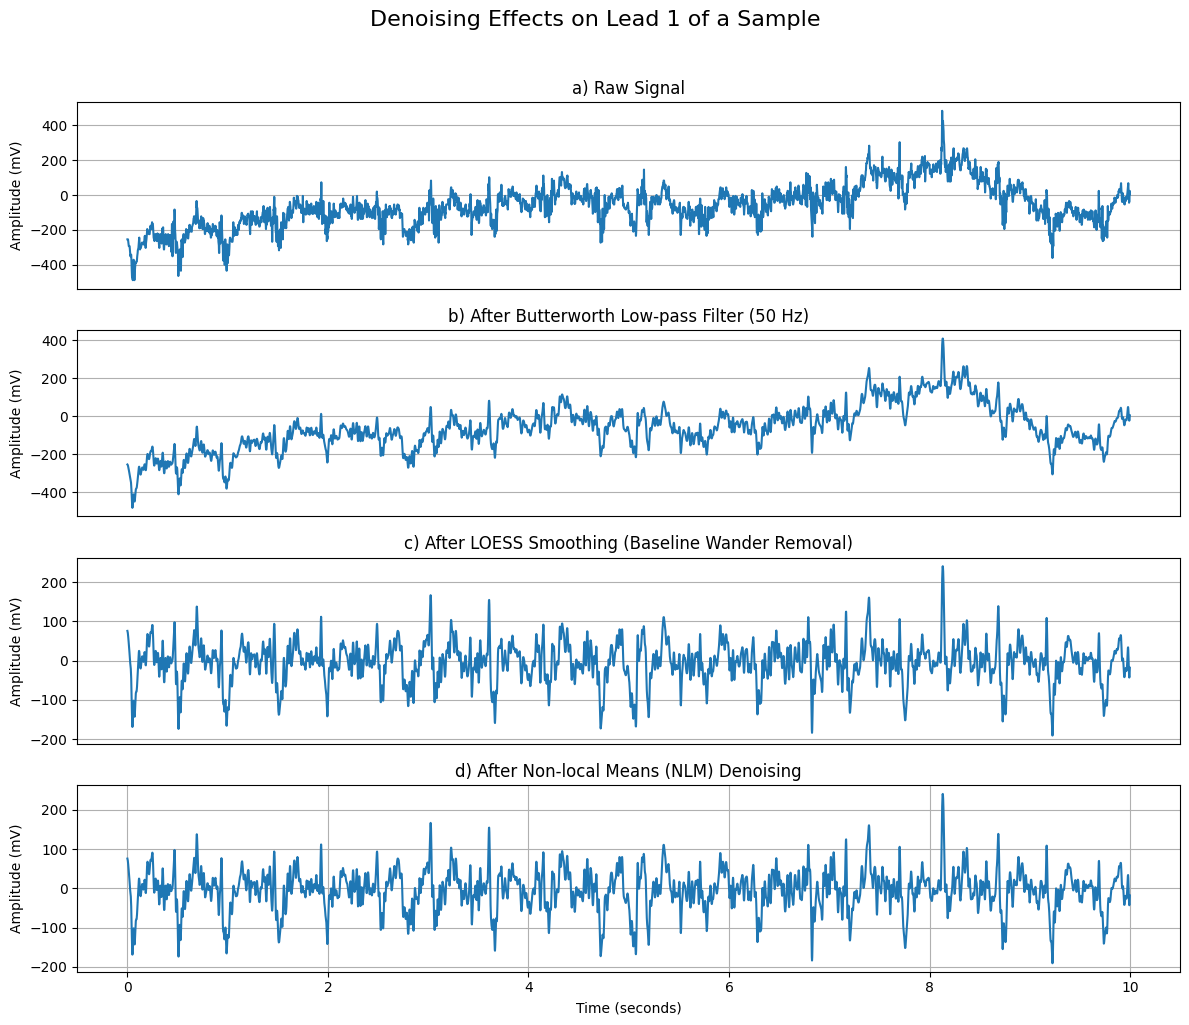

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os # Import os for path joining
from scipy.io import loadmat # Import loadmat for reloading raw data
from scipy.signal import butter, filtfilt # Import filter functions
from statsmodels.nonparametric.smoothers_lowess import lowess # Import lowess
import cv2 # Import cv2 for NLM
import logging # Import logging

# 10. Visualize Denoising Effects

logging.info("Starting visualization of denoising effects.")
print("\nVisualizing denoising effects on the first sample of the first raw batch (if available)...")

# We need the original raw signal for comparison.
# Since we've been processing in batches and clearing 'all_signals',
# we will attempt to reload the first sample from the *first* raw data batch
# and apply the filters sequentially to it for plotting.

raw_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/raw_batches'
raw_signal_batch_files = sorted([f for f in os.listdir(raw_batches_dir) if f.startswith('raw_signal_batch_') and f.endswith('.npy')])
raw_label_batch_files = sorted([f for f in os.listdir(raw_batches_dir) if f.startswith('raw_label_batch_') and f.endswith('.npy')])


raw_signal = None
record_name = "N/A (Batch data)" # Default if cannot retrieve name
fs = 500 # Default sampling frequency

if raw_signal_batch_files:
    first_raw_signal_batch_path = os.path.join(raw_batches_dir, raw_signal_batch_files[0])
    try:
        first_raw_batch_signals = np.load(first_raw_signal_batch_path)
        if first_raw_batch_signals.shape[0] > 0:
            raw_signal = first_raw_batch_signals[0] # Get the first signal from the first batch

            # Attempt to get the corresponding record name and sampling frequency
            if raw_label_batch_files and len(raw_label_batch_files) > 0:
                 first_raw_label_batch_path = os.path.join(raw_batches_dir, raw_label_batch_files[0])
                 try:
                     first_raw_batch_labels = np.load(first_raw_label_batch_path, allow_pickle=True)
                     if first_raw_batch_labels.shape[0] > 0:
                         # We don't have record names saved directly in batches.
                         # We would need to load the original record names list and map.
                         # For simplicity in visualization, we'll just use a placeholder name.
                         # If specific record names are needed here, they must be saved in the batch files.
                         pass # Placeholder - cannot easily get original record name from batch alone

                 except Exception as e:
                     logging.warning(f"Could not load first raw label batch to potentially find record name: {e}")


            # Attempt to get sampling frequency from .hea if we can derive the record name
            # This is complex as batch processing loses individual record identity.
            # Assuming a consistent sampling frequency of 500 Hz as stated in the preprocessing steps.
            fs = 500
            logging.info(f"Using assumed sampling frequency {fs} Hz for visualization.")

    except Exception as e:
        logging.error(f"Error loading the first raw signal batch for visualization: {e}. Skipping visualization.")
        print(f"Error loading the first raw signal batch for visualization: {e}. Skipping visualization.")


if raw_signal is not None:
    time = np.arange(raw_signal.shape[0]) / fs
    num_leads = raw_signal.shape[1]

    # Select one lead to plot the denoising effects (e.g., Lead 1)
    lead_to_plot = 0 # Index of Lead 1
    logging.info(f"Visualizing denoising effects on Lead {lead_to_plot + 1}.")

    # Apply filters sequentially to the raw signal for visualization
    signal_butterworth = np.zeros_like(raw_signal)
    signal_loess = np.zeros_like(raw_signal)
    signal_nlm = np.zeros_like(raw_signal)

    # 1. Butterworth
    filter_order = 4
    cutoff_frequency = 50
    sampling_frequency = fs
    normalized_cutoff_frequency = cutoff_frequency / (sampling_frequency / 2)
    b, a = butter(filter_order, normalized_cutoff_frequency, btype='lowpass')
    for lead_idx in range(num_leads):
         signal_butterworth[:, lead_idx] = filtfilt(b, a, raw_signal[:, lead_idx])
    logging.info("Applied Butterworth filter for visualization.")


    # 2. LOESS
    loess_frac = 0.05
    for lead_idx in range(num_leads):
        lead_data = signal_butterworth[:, lead_idx]
        time_points = np.arange(len(lead_data))
        try:
            smoothed_baseline = lowess(lead_data, time_points, frac=loess_frac, return_sorted=False)
            signal_loess[:, lead_idx] = lead_data - smoothed_baseline
        except Exception as e:
            logging.error(f"Error applying LOESS for visualization on lead {lead_idx}: {e}. Using Butterworth signal for this lead.")
            print(f"Error applying LOESS for visualization on lead {lead_idx}: {e}. Using Butterworth signal for this lead.")
            signal_loess[:, lead_idx] = signal_butterworth[:, lead_idx] # Use Butterworth signal if LOESS fails

    logging.info("Applied LOESS filter for visualization.")

    # 3. NLM (Applying to the LOESS result)
    nlm_h = 10
    nlm_template_window_size = 7
    nlm_search_window_size = 21

    # Convert to uint8 for NLM (scaling needed)
    min_val = np.min(signal_loess)
    max_val = np.max(signal_loess)
    if max_val - min_val > 0:
        signal_scaled_loess = 255 * (signal_loess - min_val) / (max_val - min_val)
    else:
        signal_scaled_loess = np.zeros_like(signal_loess)

    signal_uint8_loess = signal_scaled_loess.astype(np.uint8)

    for lead_idx in range(num_leads):
        lead_data_uint8 = signal_uint8_loess[:, lead_idx] # This is a 1D array

        try:
            denoised_lead_uint8 = cv2.fastNlMeansDenoising(lead_data_uint8, None, nlm_h, nlm_template_window_size, nlm_search_window_size)

            if max_val - min_val > 0:
                signal_nlm[:, lead_idx] = (denoised_lead_uint8 / 255.0) * (max_val - min_val) + min_val
            else:
                 signal_nlm[:, lead_idx] = np.zeros_like(denoised_lead_uint8).astype(signal_loess.dtype)
        except Exception as e:
            logging.error(f"Error applying NLM for visualization on lead {lead_idx}: {e}. Using LOESS signal for this lead.")
            print(f"Error applying NLM for visualization on lead {lead_idx}: {e}. Using LOESS signal for this lead.")
            signal_nlm[:, lead_idx] = signal_loess[:, lead_idx] # Use LOESS signal for this lead

    logging.info("Applied NLM denoising for visualization.")

    # Plotting
    plt.figure(figsize=(12, 10))
    plt.suptitle(f'Denoising Effects on Lead {lead_to_plot+1} of a Sample', y=1.02, fontsize=16) # Use generic title


    # Plot Raw Signal
    plt.subplot(4, 1, 1)
    plt.plot(time, raw_signal[:, lead_to_plot])
    plt.title('a) Raw Signal')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    plt.xticks([]) # Hide x-axis ticks

    # Plot after Butterworth
    plt.subplot(4, 1, 2)
    plt.plot(time, signal_butterworth[:, lead_to_plot])
    plt.title('b) After Butterworth Low-pass Filter (50 Hz)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    plt.xticks([]) # Hide x-axis ticks

    # Plot after LOESS
    plt.subplot(4, 1, 3)
    plt.plot(time, signal_loess[:, lead_to_plot])
    plt.title('c) After LOESS Smoothing (Baseline Wander Removal)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    plt.xticks([]) # Hide x-axis ticks

    # Plot after NLM
    plt.subplot(4, 1, 4)
    plt.plot(time, signal_nlm[:, lead_to_plot])
    plt.title('d) After Non-local Means (NLM) Denoising')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    logging.info(f"Visualization plotted for a sample.")


else:
    logging.warning("No raw data batch found or loaded for visualization of denoising effects.")
    print("\nNo raw data batch found or loaded for visualization of denoising effects.")

logging.info("Visualization of denoising effects complete.")

In [33]:
from sklearn.preprocessing import StandardScaler
import os # Import os for path joining
import numpy as np # Ensure numpy is imported
import logging # Import logging

print("\nApplying lead-wise z-score standardization...")
logging.info("Starting lead-wise z-score standardization...")

# Define the directory for saving normalized data batches
save_directory_normalized = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/normalized'
os.makedirs(save_directory_normalized, exist_ok=True) # Create the directory if it doesn't exist
logging.info(f"Saving normalized data batches to: {save_directory_normalized}")

# Load NLM denoised batches and process in batches for Normalization
nlm_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/nlm'

# Add a check for directory existence before listing
if not os.path.exists(nlm_batches_dir):
    logging.error(f"NLM denoised batches directory not found: {nlm_batches_dir}. Please ensure the NLM denoising cell ran successfully.")
    print(f"Error: NLM denoised batches directory not found at {nlm_batches_dir}. Please ensure the NLM denoising cell ran successfully and re-run.")
    nlm_signal_batch_files = [] # Set to empty list to prevent further errors
else:
    nlm_signal_batch_files = sorted([f for f in os.listdir(nlm_batches_dir) if f.startswith('nlm_denoised_signal_batch_') and f.endswith('.npy')])
    logging.info(f"Found {len(nlm_signal_batch_files)} NLM denoised batches to process for Normalization.")


for batch_index, batch_file in enumerate(nlm_signal_batch_files):
    nlm_signal_batch_path = os.path.join(nlm_batches_dir, batch_file)
    batch_save_path = os.path.join(save_directory_normalized, f'normalized_signal_batch_{batch_index}.npy')

    # Check if the processed batch already exists to skip reprocessing
    if os.path.exists(batch_save_path):
        logging.info(f"Normalized batch {batch_index} already exists. Skipping processing for this batch.")
        continue # Skip to the next batch if already processed
    # --- Save only if the batch was not skipped ---
    else:
        try:
            # Load the current NLM denoised data batch
            current_batch_signals = np.load(nlm_signal_batch_path)
            logging.info(f"Loaded NLM denoised batch {batch_index} with shape {current_batch_signals.shape}.")

            # Initialize a list to store normalized signals for the current batch
            normalized_batch_signals = []

            # Apply z-score standardization to each lead of each signal within the current batch
            for signal in current_batch_signals:
                normalized_signal = np.zeros_like(signal)
                # Initialize StandardScaler for each lead
                scaler = StandardScaler()
                for lead_idx in range(signal.shape[1]): # Iterate through each lead
                    lead_data = signal[:, lead_idx]

                    # Reshape the lead data to be a 2D array (n_samples, n_features) for StandardScaler
                    # Since each lead is a single feature over time, n_features is 1.
                    lead_data_reshaped = lead_data.reshape(-1, 1)

                    # Fit and transform the lead data
                    normalized_lead_reshaped = scaler.fit_transform(lead_data_reshaped)

                    # Reshape back to a 1D array
                    normalized_lead = normalized_lead_reshaped.reshape(-1)

                    normalized_signal[:, lead_idx] = normalized_lead
                normalized_batch_signals.append(normalized_signal)

            # Convert the list of normalized signals for the batch to a NumPy array
            normalized_batch_signals_np = np.array(normalized_batch_signals)

            # Save the current batch of normalized signals
            np.save(batch_save_path, normalized_batch_signals_np)
            logging.info(f"Normalized signal batch {batch_index} saved.")

            # Optional: Verify normalization on a lead of the first sample in the batch
            if len(normalized_batch_signals_np) > 0:
                example_lead = normalized_batch_signals_np[0][:, 0] # First lead of the first sample in the batch
                logging.info(f"Verification (Batch {batch_index}): Mean of the first lead after normalization: {np.mean(example_lead):.4f}")
                logging.info(f"Verification (Batch {batch_index}): Standard deviation of the first lead after normalization: {np.std(example_lead):.4f}")


        except Exception as e:
            logging.error(f"Error processing or saving Normalization batch {batch_index}: {e}. Skipping this batch.")
            pass # Continue to the next batch


print("Lead-wise z-score standardization applied in batches.")
logging.info("Lead-wise z-score standardization applied in batches.")

# After processing all batches, 'all_signals' will be empty as we are processing and saving batches directly.
# Subsequent steps (like SMOTE-Tomek or final saving) will need to load from the saved normalized batches.
all_signals = []
logging.info("'all_signals' cleared after batch processing.")

# Note: The 'all_labels' variable is not updated here as labels are typically not transformed in these steps.
# Labels were loaded and potentially saved in batches during the initial data loading step.
# Subsequent steps that require labels (like SMOTE-Tomek or final saving) will need to load them
# from the raw label batches or a consolidated label file if created.


Applying lead-wise z-score standardization...
Lead-wise z-score standardization applied in batches.


In [34]:
# Install imbalanced-learn if you haven't already
!pip install imbalanced-learn --quiet

In [35]:
from imblearn.combine import SMOTETomek
from collections import Counter
import numpy as np
import pandas as pd # Import pandas for displaying counts
import logging # Import logging
import os # Import os for path joining

print("\nApplying SMOTE-Tomek to address class imbalance...")
logging.info("Starting SMOTE-Tomek for class imbalance...")

# SMOTE-Tomek requires the data to be in a suitable format (e.g., NumPy arrays)
# and the labels to be integers or strings that can be processed.
# Our current data is saved in normalized batches. We need to load and consolidate these batches.

normalized_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/normalized'
# Labels were saved in the raw batches step, and should have been carried through the cleaning step.
# We should load labels from the cleaned batches directory to ensure they correspond to the cleaned signals.
cleaned_labels_batches_dir = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed/intermediate/cleaned'

# List normalized signal batch files
normalized_signal_batch_files = sorted([f for f in os.listdir(normalized_batches_dir) if f.startswith('normalized_signal_batch_') and f.endswith('.npy')])
# List cleaned label batch files
cleaned_label_batch_files = sorted([f for f in os.listdir(cleaned_labels_batches_dir) if f.startswith('cleaned_label_batch_') and f.endswith('.npy')])


# Ensure signal and label batches match in count
if len(normalized_signal_batch_files) != len(cleaned_label_batch_files):
     logging.error("Mismatch in the number of normalized signal and cleaned label batch files. Cannot proceed with SMOTE-Tomek.")
     print("Error: Mismatch in the number of normalized signal and cleaned label batch files. Cannot proceed with SMOTE-Tomek.")
     # Clear the data to prevent subsequent steps from using inconsistent data
     all_signals = []
     all_labels = []
else:
    # Load and consolidate normalized signals
    all_normalized_signals = []
    for batch_file in normalized_signal_batch_files:
        try:
            batch_signals = np.load(os.path.join(normalized_batches_dir, batch_file))
            all_normalized_signals.append(batch_signals)
            logging.info(f"Loaded normalized signal batch: {batch_file}")
        except Exception as e:
            logging.error(f"Error loading normalized signal batch {batch_file}: {e}. Skipping batch.")

    # Load and consolidate cleaned labels
    all_cleaned_labels = []
    for batch_file in cleaned_label_batch_files:
        try:
            batch_labels = np.load(os.path.join(cleaned_labels_batches_dir, batch_file), allow_pickle=True) # Use allow_pickle=True for object arrays (strings)
            # Extend the list in case batch_labels is an array of multiple labels
            if isinstance(batch_labels, np.ndarray):
                 all_cleaned_labels.extend(batch_labels.tolist()) # Convert numpy array to list and extend
            else:
                 all_cleaned_labels.append(batch_labels) # Append if it's a single label
            logging.info(f"Loaded cleaned label batch: {batch_file}")
        except Exception as e:
            logging.error(f"Error loading cleaned label batch {batch_file}: {e}. Skipping batch.")


    # Check if any data was loaded
    if all_normalized_signals and all_cleaned_labels:
        # Consolidate the list of arrays into a single NumPy array
        # Ensure labels match the number of loaded signals
        num_loaded_signals = sum([batch.shape[0] for batch in all_normalized_signals])
        if num_loaded_signals != len(all_cleaned_labels):
             logging.error(f"Number of loaded signals ({num_loaded_signals}) does not match the number of loaded labels ({len(all_cleaned_labels)}). SMOTE-Tomek cannot be applied accurately. Skipping SMOTE-Tomek.")
             print(f"\nError: Number of loaded signals ({num_loaded_signals}) does not match the number of loaded labels ({len(all_cleaned_labels)}). SMOTE-Tomek cannot be applied accurately. Skipping SMOTE-Tomek.")
             # Clear the data to prevent subsequent steps from using inconsistent data
             all_signals = []
             all_labels = []
        else:

            # Consolidate signals by stacking the loaded batches
            stacked_signals = np.vstack(all_normalized_signals) # Stack along the first dimension (samples)

            # Reshape signals for SMOTE-Tomek: expected shape (n_samples, n_features).
            # Our stacked signals are (n_samples, 5000, 12).
            # We need to flatten each signal into a 1D feature vector (5000 * 12 = 60000 features per sample).
            n_samples = stacked_signals.shape[0]
            signal_shape = stacked_signals.shape[1:] # (5000, 12)
            n_features_per_sample = signal_shape[0] * signal_shape[1] # 5000 * 12 = 60000

            X = stacked_signals.reshape(n_samples, n_features_per_sample) # Shape: (n_samples, 60000)

            # Convert consolidated labels list to a NumPy array
            y = np.array(all_cleaned_labels) # Use cleaned labels

            logging.info(f"Consolidated dataset shape for SMOTE-Tomek (samples, flattened features): {X.shape}")
            logging.info(f"Consolidated labels shape: {y.shape}")
            original_counts = Counter(y)
            logging.info(f"Original class distribution: {original_counts}")
            print(f"Consolidated dataset shape for SMOTE-Tomek (samples, flattened features): {X.shape}")
            print(f"Consolidated labels shape: {y.shape}")
            print("Original class distribution:", original_counts)

            # Initialize SMOTE-Tomek
            # We can set a sampling_strategy. 'auto' balances all classes to match the majority class.
            # Or we can specify a dictionary to balance to a specific number of samples per class.
            # Let's aim for a modest increase in minority classes.

            sampling_strategy_dict = {}
            # Aim to bring minority classes up to a certain level (e.g., 50% of majority class count)
            if original_counts: # Ensure original_counts is not empty
                majority_class_count = max(original_counts.values())
                min_target_count = int(majority_class_count * 0.5) # Example target: 50% of majority

                for class_name, count in original_counts.items():
                    if count < majority_class_count: # Only oversample minority classes
                         # Aim for at least the minimum target count, but not exceeding majority count
                         sampling_strategy_dict[class_name] = max(count, min_target_count)
                    else:
                         sampling_strategy_dict[class_name] = count # Keep majority class count

                # Check if sampling_strategy_dict is meaningful (i.e., if there are minority classes to oversample to a higher count)
                if any(target > original_counts.get(class_name, 0) for class_name, target in sampling_strategy_dict.items()):
                    logging.info(f"Applying SMOTE-Tomek with sampling strategy: {sampling_strategy_dict}")
                    print(f"Applying SMOTE-Tomek with sampling strategy: {sampling_strategy_dict}")
                    smote_tomek = SMOTETomek(sampling_strategy=sampling_strategy_dict, random_state=42)

                    try:
                        # Apply SMOTE-Tomek
                        X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

                        logging.info(f"Resampled dataset shape (samples, flattened features): {X_resampled.shape}")
                        resampled_counts = Counter(y_resampled)
                        logging.info(f"Resampled class distribution: {resampled_counts}")
                        print(f"\nResampled dataset shape (samples, flattened features): {X_resampled.shape}")
                        print("Resampled class distribution:", resampled_counts)

                        # Update the main data variables to use the resampled data
                        # We need to reshape the resampled signals back to their original 3D shape (samples, 5000, 12)
                        # The number of samples will be the new number of samples after resampling.
                        n_samples_resampled = X_resampled.shape[0]
                        all_signals = list(X_resampled.reshape(n_samples_resampled, signal_shape[0], signal_shape[1]))

                        all_labels = list(y_resampled) # Convert back to list

                        logging.info("Updated 'all_signals' and 'all_labels' to contain the SMOTE-Tomek resampled data.")
                        print("\nUpdated 'all_signals' and 'all_labels' to contain the SMOTE-Tomek resampled data.")

                    except Exception as e:
                        logging.error(f"Error applying SMOTE-Tomek: {e}. Skipping SMOTE-Tomek and using the original consolidated normalized data.")
                        print(f"\nError applying SMOTE-Tomek: {e}. Skipping SMOTE-Tomek and using the original consolidated normalized data.")
                        # If SMOTE-Tomek fails, keep the data as is (consolidated normalized but imbalanced)
                        all_signals = list(stacked_signals.reshape(n_samples, signal_shape[0], signal_shape[1])) # Use the consolidated normalized signals
                        all_labels = list(y) # Use the original consolidated labels

                else:
                    logging.info("No significant class imbalance found or sampling strategy resulted in no oversampling. Skipping SMOTE-Tomek.")
                    print("\nNo significant class imbalance found or sampling strategy resulted in no oversampling. Skipping SMOTE-Tomek.")
                    # If SMOTE-Tomek is skipped, use the consolidated normalized data
                    all_signals = list(stacked_signals.reshape(n_samples, signal_shape[0], signal_shape[1]))
                    all_labels = list(y)
            else:
                 logging.warning("Original class distribution is empty. Cannot apply SMOTE-Tomek.")
                 print("\nOriginal class distribution is empty. Cannot apply SMOTE-Tomek.")
                 # If no data or empty class distribution, ensure all_signals and all_labels are empty
                 all_signals = []
                 all_labels = []


    else:
        logging.warning("No normalized data batches or cleaned label batches found to apply SMOTE-Tomek.")
        print("\nNo normalized data batches or cleaned label batches found to apply SMOTE-Tomek.")
        # If no data batches are found, ensure all_signals and all_labels are empty
        all_signals = []
        all_labels = []


logging.info("SMOTE-Tomek process complete.")


Applying SMOTE-Tomek to address class imbalance...
Error: Mismatch in the number of normalized signal and cleaned label batch files. Cannot proceed with SMOTE-Tomek.


In [36]:
import os
import numpy as np
import logging # Import logging

# Define the directory to save the processed data
save_directory = '/content/drive/My Drive/ECG_Arrhythmia_Project/data/processed'

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Define the file paths for saving the consolidated data
features_save_path = os.path.join(save_directory, 'preprocessed_features.npy')
labels_save_path = os.path.join(save_directory, 'preprocessed_labels.npy')

# all_signals and all_labels should contain the final preprocessed data after all steps (including normalization and potentially SMOTE-Tomek)

logging.info("Starting consolidation and saving of final preprocessed data.")
print("\nStarting consolidation and saving of final preprocessed data.")

# Convert the list of signals and labels to NumPy arrays before saving
# These variables should hold the final data after SMOTE-Tomek if applied,
# otherwise the consolidated normalized data.
final_features = np.array(all_signals)
final_labels = np.array(all_labels)

# Save the NumPy arrays
if final_features.size > 0 and final_labels.size > 0 and len(final_features) == len(final_labels):
    try:
        np.save(features_save_path, final_features)
        np.save(labels_save_path, final_labels)
        logging.info(f"Consolidated preprocessed features saved to: {features_save_path} with shape {final_features.shape}")
        logging.info(f"Consolidated preprocessed labels saved to: {labels_save_path} with shape {final_labels.shape}")
        print(f"\nConsolidated preprocessed features saved to: {features_save_path} with shape {final_features.shape}")
        print(f"Consolidated preprocessed labels saved to: {labels_save_path} with shape {final_labels.shape}")
        logging.info("Final data consolidation and saving complete.")
    except Exception as e:
        logging.error(f"An error occurred while saving the consolidated preprocessed data: {e}")
        print(f"An error occurred while saving the consolidated preprocessed data: {e}")
        logging.error("Final data consolidation and saving failed.")
else:
    logging.warning("No data to save or mismatch in features and labels size.")
    print("\nNo data to save or mismatch in features and labels size.")
    logging.warning("Final data consolidation and saving skipped due to no data or size mismatch.")


Starting consolidation and saving of final preprocessed data.

No data to save or mismatch in features and labels size.
